# NBA Team Clustering - Finding Team Archetypes based off Team Statistics

# Introduction - Project Summary

This project is an exploratory unsupervised machine learning analysis focused on uncovering patterns and differences among NBA teams using team-level performance data from the 2014 to 2024 seasons. The primary objective is to investigate whether teams can be grouped into distinct clusters based on statistical profiles — and whether these clusters relate to playoff success.

The analysis centers on the K-Means clustering algorithm, which is applied to standardized team statistics to discover natural groupings of team archetypes. After selecting the optimal number of clusters using both the elbow method and silhouette analysis, teams are clustered and evaluated based on feature characteristics, cluster composition, and playoff performance.

Additional analyses explore how these clusters evolve over time, revealing broader shifts in team strategy — such as the NBA's transition toward faster-paced, three-point-heavy offenses. Emphasis is placed on interpretability, using visualizations, feature comparisons, and descriptive labels to make sense of the resulting clusters.

This project highlights how K-Means clustering can be used to extract insights from unlabeled sports data and illustrate the evolution of team identities in the NBA.

### Import Initial Libraries and datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Team Totals
team_totals = pd.read_csv('data/Team Totals.csv')

# Team Stats per game
team_stats_per_game = pd.read_csv('data/Team Stats Per Game.csv')

# Team Summaries
team_summaries = pd.read_csv('data/Team Summaries.csv')

# EDA

## Filter and Inspect the Data
    Filter to NBA Seasons 2014-2024

In [3]:
# Filter for NBA teams only and seasons from 2014 to 2024
team_stats = team_stats_per_game[
    (team_stats_per_game['lg'] == 'NBA') &
    (team_stats_per_game['season'].between(2014, 2024))
].copy()

Inspect datatypes of features and dataset

In [4]:
# Check basic structure
print(team_stats.shape)
print(team_stats.dtypes)
team_stats.head(5)

(341, 28)
season             int64
lg                object
team              object
abbreviation      object
playoffs            bool
g                float64
mp_per_game      float64
fg_per_game      float64
fga_per_game     float64
fg_percent       float64
x3p_per_game     float64
x3pa_per_game    float64
x3p_percent      float64
x2p_per_game     float64
x2pa_per_game    float64
x2p_percent      float64
ft_per_game      float64
fta_per_game     float64
ft_percent       float64
orb_per_game     float64
drb_per_game     float64
trb_per_game     float64
ast_per_game     float64
stl_per_game     float64
blk_per_game     float64
tov_per_game     float64
pf_per_game      float64
pts_per_game     float64
dtype: object


,season,lg,team,abbreviation,playoffs,g,mp_per_game,fg_per_game,fga_per_game,fg_percent,...,ft_percent,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game
31,2024,NBA,Atlanta Hawks,ATL,False,82.0,242.1,43.0,92.5,0.465,...,0.797,12.5,32.2,44.7,26.6,7.5,4.5,13.5,18.6,118.3
32,2024,NBA,Boston Celtics,BOS,True,82.0,241.8,43.9,90.2,0.487,...,0.807,10.7,35.6,46.3,26.9,6.8,6.6,11.9,16.2,120.6
33,2024,NBA,Brooklyn Nets,BRK,False,82.0,241.5,40.7,89.1,0.456,...,0.756,11.4,32.6,44.1,25.6,6.8,5.2,13.1,18.5,110.4
34,2024,NBA,Chicago Bulls,CHI,False,82.0,243.7,42.0,89.5,0.470,...,0.791,11.2,32.6,43.8,25.0,7.8,4.8,12.2,18.8,112.3
35,2024,NBA,Charlotte Hornets,CHO,False,82.0,240.6,40.0,87.0,0.460,...,0.786,9.3,31.0,40.3,24.8,6.9,4.5,13.8,18.0,106.6


#### Drop Non-Numeric and Identifier Columns
- We’ll keep only numeric features for clustering and save the playoffs column separately for later evaluation

In [5]:
# Save labels for analysis later (not used in clustering)
team_labels = team_stats[['team', 'season', 'playoffs']].copy()

# Drop columns that are non-numeric or identifiers
cols_to_drop = ['team', 'abbreviation', 'lg', 'season', 'playoffs']
features = team_stats.drop(columns=cols_to_drop)


#### Check for missing values and print summary statistics
- No missing values in feature data so we do not have to fill any null/missing data

In [6]:
# Missing values?
print(features.isnull().sum())


g                0
mp_per_game      0
fg_per_game      0
fga_per_game     0
fg_percent       0
x3p_per_game     0
x3pa_per_game    0
x3p_percent      0
x2p_per_game     0
x2pa_per_game    0
x2p_percent      0
ft_per_game      0
fta_per_game     0
ft_percent       0
orb_per_game     0
drb_per_game     0
trb_per_game     0
ast_per_game     0
stl_per_game     0
blk_per_game     0
tov_per_game     0
pf_per_game      0
pts_per_game     0
dtype: int64


## Summary Statistics
- This can be used as comparison against model clusters

In [7]:
# Summary statistics
features.describe()

,g,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,x2pa_per_game,...,ft_percent,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game
count,341.000000,341.000000,341.00000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,...,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000
mean,80.055718,241.630205,40.00176,86.759824,0.460968,10.737537,29.933724,0.358038,29.265396,56.824927,...,0.769428,10.331085,33.535191,43.864809,23.871261,7.629912,4.840469,14.140469,20.022287,108.191496
std,4.253698,0.813740,2.17219,3.059959,0.016300,2.402045,6.303361,0.016452,1.980457,4.971430,...,0.029568,1.146081,1.715207,1.942419,2.358201,0.790151,0.720134,1.112683,1.431259,6.315272
min,64.000000,240.000000,33.70000,76.500000,0.408000,4.900000,14.000000,0.312000,23.100000,41.900000,...,0.668000,7.600000,29.200000,36.900000,18.000000,5.500000,2.400000,11.100000,15.600000,91.900000
25%,82.000000,241.000000,38.40000,84.800000,0.450000,9.000000,25.100000,0.348000,27.900000,53.500000,...,0.752000,9.500000,32.300000,42.700000,22.100000,7.100000,4.300000,13.400000,18.900000,103.400000
50%,82.000000,241.500000,39.90000,87.000000,0.461000,11.000000,31.000000,0.357000,29.300000,56.500000,...,0.772000,10.300000,33.600000,43.900000,23.800000,7.600000,4.800000,14.100000,20.000000,108.600000
75%,82.000000,242.100000,41.70000,88.800000,0.472000,12.500000,34.300000,0.369000,30.800000,60.600000,...,0.788000,11.000000,34.600000,45.100000,25.500000,8.200000,5.300000,14.900000,21.000000,113.400000
max,82.000000,244.600000,47.00000,94.400000,0.507000,16.700000,45.400000,0.416000,33.900000,68.300000,...,0.839000,14.600000,42.200000,51.700000,30.800000,10.000000,7.500000,17.700000,24.800000,123.300000


## Correlation Matrix
- to help identify relationships between features

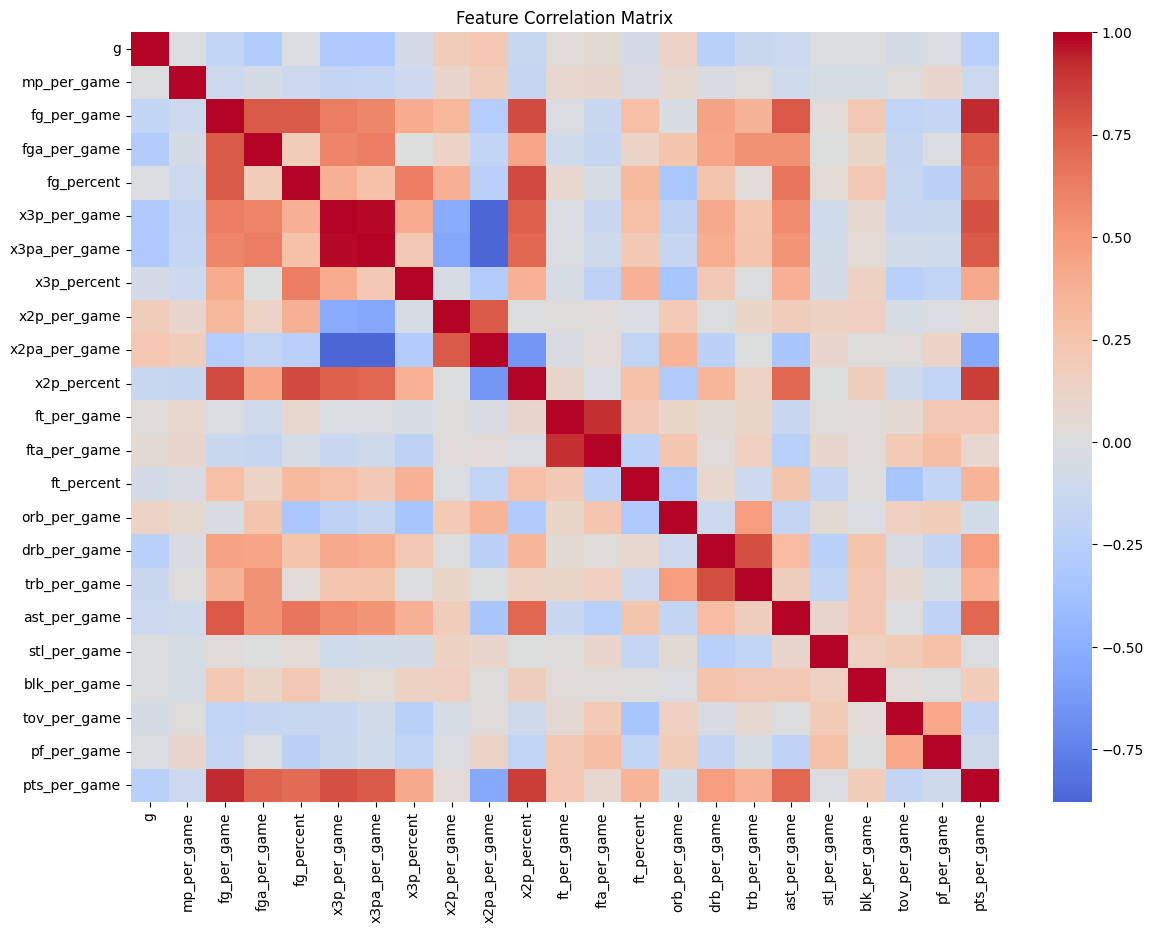

In [8]:
plt.figure(figsize=(14, 10))
corr_matrix = features.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

## Visualize Distributions
- visualize the distributions of key features in the dataset

    1. Histogram for Points Per Game shows a Non-symmetric bimodal distribution (two peaks) of scoring. This indicates that there is a high concentration of teams averaging about 105 points per game as well as about 115 points per game. This indicates points per game could be an important feature to clustering the data.

    2. Histogram of Field Goal Attempts (FGA) per game shows a normal distribution. This tighter, bell-shaped curve suggests that most NBA teams attempt a similar volume of shots per game, indicating that scoring differences are likely influenced by team efficiency in 2p% and 3p%. I would like to know how FGA, either higher or belower the mean, impact a teams performance. 

    3. The boxplot comparison of ast_per_game and tov_per_game highlights a meaningful gap between these two key playmaking metrics. Teams average significantly more assists (around 22–26 per game) than turnovers (around 13–15), though some outliers exist on both ends. The presence of high-assist outliers may indicate teams with exceptional ball movement and offensive coordination, while low-turnover teams may emphasize control and disciplined play — traits that could separate successful teams in later analysis.

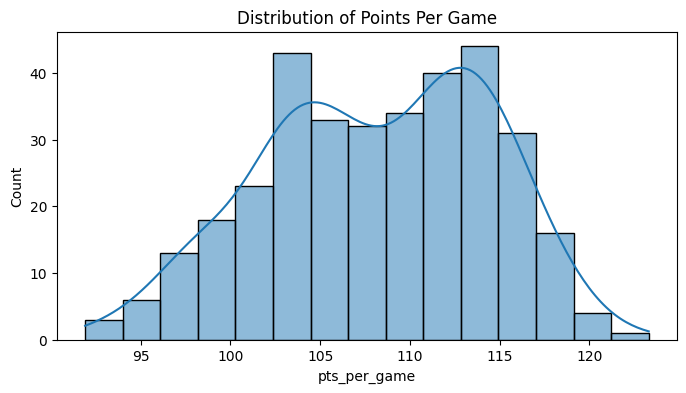

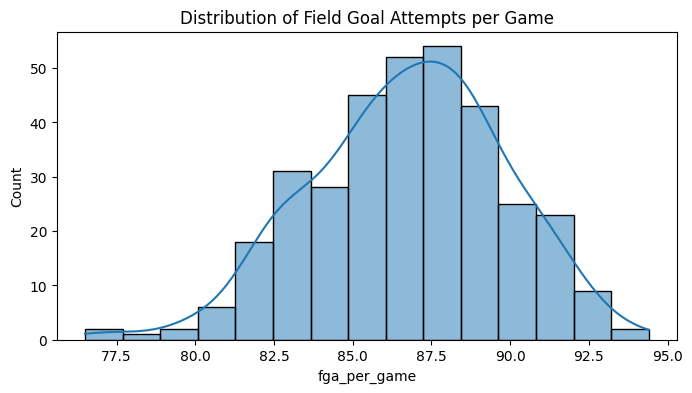

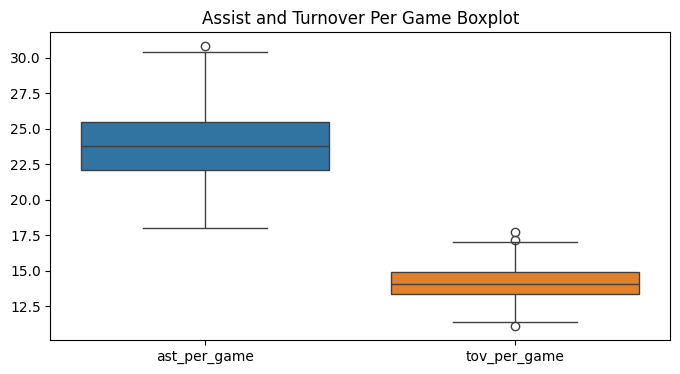

In [9]:
# Histogram of points per game
plt.figure(figsize=(8, 4))
sns.histplot(features['pts_per_game'], kde=True, bins=15)
plt.title('Distribution of Points Per Game')
plt.show()

# Histogram of FGA per game
plt.figure(figsize=(8, 4))
sns.histplot(features['fga_per_game'], kde=True, bins=15)
plt.title('Distribution of Field Goal Attempts per Game')
plt.show()


# Boxplot for assists and turnovers per game
plt.figure(figsize=(8, 4))
sns.boxplot(data=features[['ast_per_game', 'tov_per_game']])
plt.title('Assist and Turnover Per Game Boxplot')
plt.show()


# Model Building

## Normalize Features before applying clustering algorithms using z-score normalization via StandardScaler
    - This transformation centers each feature around a mean of 0 and scales it to have a standard deviation of 1. This ensures no single feature dominates the clustering algorithm.
    - The resulting scaled_df is used throughout the rest of the analysis for clustering and dimensionality reduction.

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert back to DataFrame for convenience
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)


## Boxplots Comparing Playoff vs Non-Playoff Teams using Standardized Features
    
    - Using the scaled dataset, I wanted to compare key features using box plots to show distributions for playoff vs not playoff teams.
    
    - As you may have expected, Points per game, Assists per game, Total Rebounds per game, and Steals per game had distributions higher than teams that did not make playoffs.
    
    - Field Goal Attempts per game seemed to have distributions pretty similar between playoff vs not playoff.
    
    - Turnovers per game had much less variance for the playoff teams as well as a lower median.
    
    

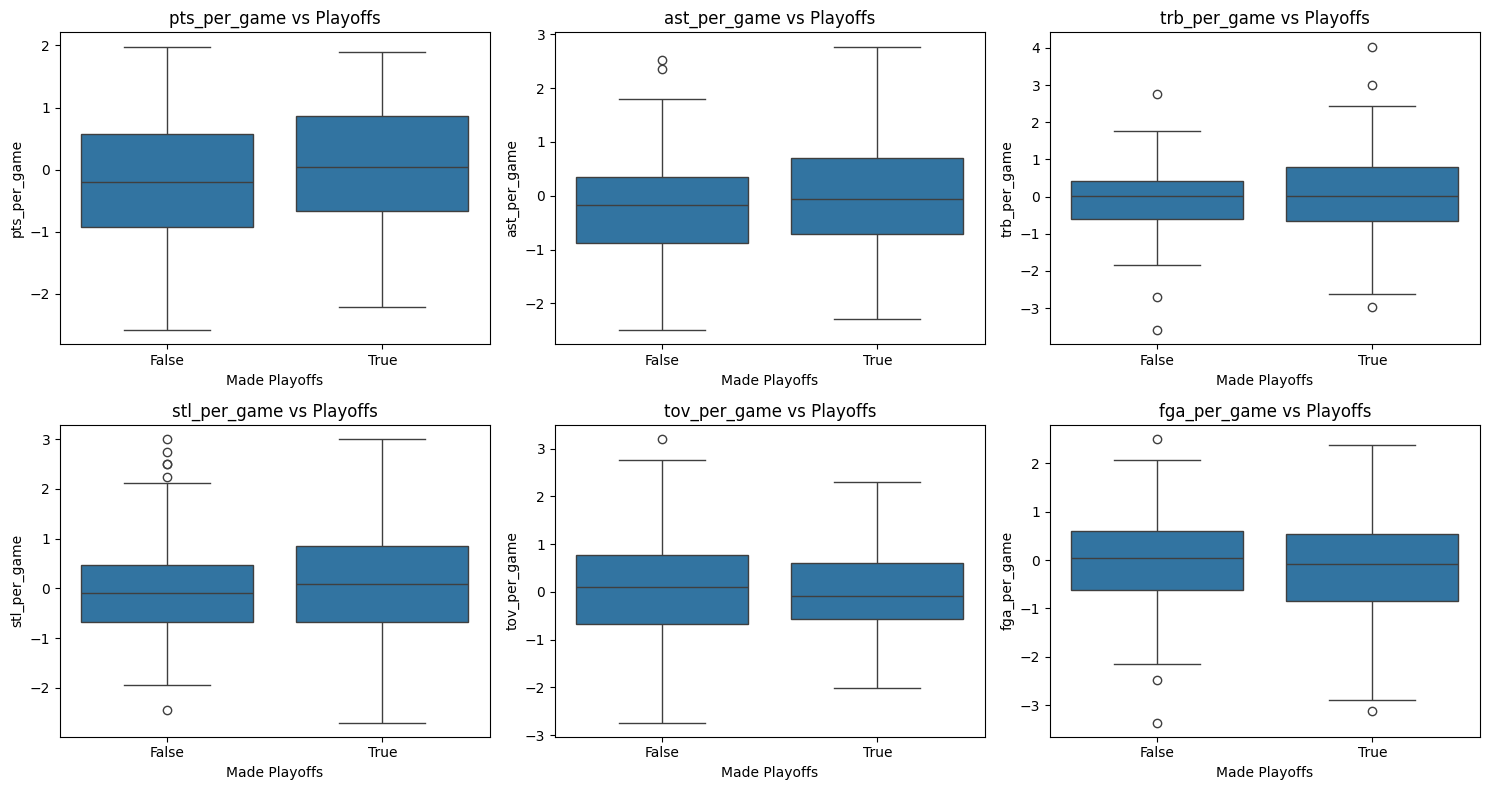

In [11]:
# Combine scaled features with playoff labels
eda_df = scaled_df.copy()
eda_df['playoffs'] = team_labels['playoffs'].astype(bool)

# Pick a few interesting features
features_to_plot = ['pts_per_game', 'ast_per_game', 'trb_per_game', 'stl_per_game', 'tov_per_game', 'fga_per_game']

plt.figure(figsize=(15, 8))
for i, col in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=eda_df, x='playoffs', y=col)
    plt.title(f'{col} vs Playoffs')
    plt.xlabel('Made Playoffs')
plt.tight_layout()
plt.show()


## Standardized Feature Average (Playoff vs Non-Playoff)
    - Again using the scaled feature set, this bar chart helps to show the differences between features for playoff vs non-playoff teams.
    - Key Features identified were:
        - fg_percent (Field Goal Percentage)
        - x3pa_per_game (3 Pointers Attempted)
        - x2pa_per_game (2 Pointers Attempted)
        - x2p_percent (2 Point Field Goal Percentage)
        - ft_per_game (Free Throws per game)
        - trb_per_game (Total Rebounds per game)

<Figure size 1200x600 with 0 Axes>

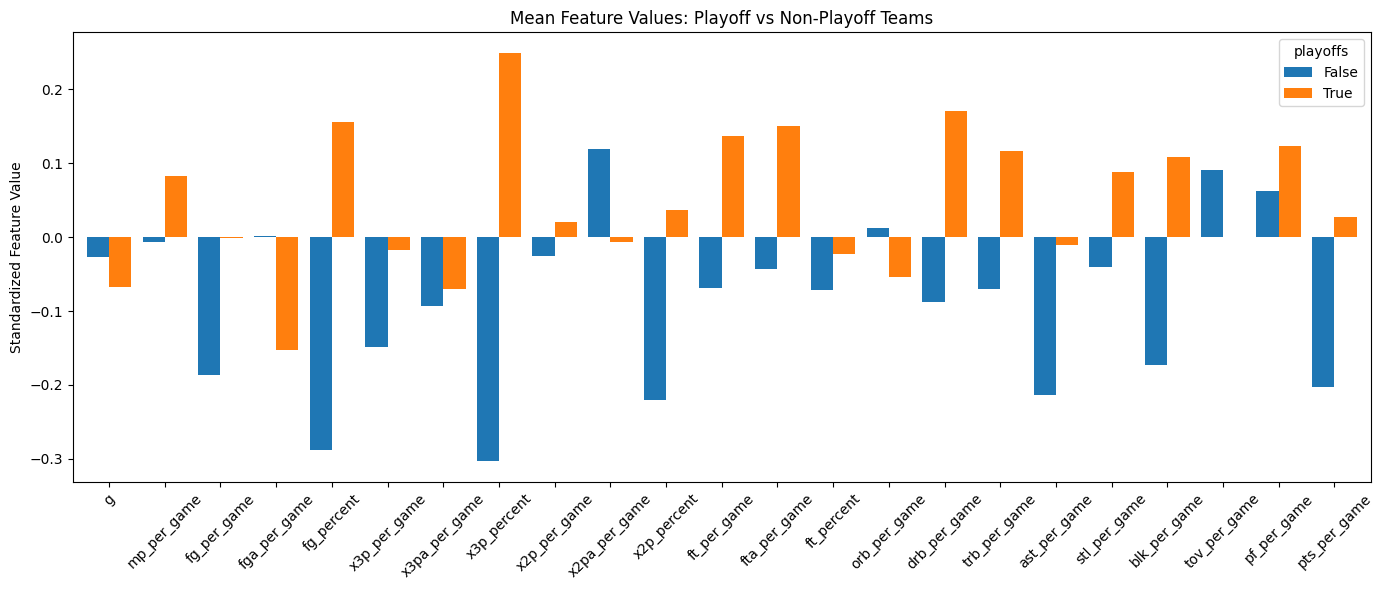

In [12]:
# Group by playoff status and get mean for each feature
group_means = eda_df.groupby('playoffs').mean().T

# Plot the differences
plt.figure(figsize=(12, 6))
group_means.plot(kind='bar', figsize=(14,6), width=0.8)
plt.title('Mean Feature Values: Playoff vs Non-Playoff Teams')
plt.ylabel('Standardized Feature Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Identify Multicollinearity and removed redundant features

To avoid redundancy and reduce multicollinearity in the dataset, I calculated the absolute correlation matrix for all numeric features and identified feature pairs with a correlation greater than 0.90. High correlation between features can bias clustering models by overemphasizing certain dimensions that essentially represent the same information.

The following steps were performed:

1. Compute the absolute correlation matrix to assess the strength of linear relationships between all features.

2. Mask the upper triangle of the matrix to avoid duplicate pairs and self-correlations.

3. Extract and sort highly correlated feature pairs (correlation > 0.90).

4. From each highly correlated pair, one feature was selected to drop — ensuring we retain only one feature from each redundant pair.

This dimensionality reduction step improves model performance and interpretability by ensuring that all remaining features provide distinct, independent contributions to clustering.

In [13]:
# Get correlation matrix
corr = features.corr().abs()

# Mask the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
tri_corr = corr.mask(mask)

# Find highly correlated features (excluding self-correlation)
redundant_pairs = tri_corr.stack().reset_index()
redundant_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr = redundant_pairs[redundant_pairs['Correlation'] > 0.9]

high_corr.sort_values(by='Correlation', ascending=False)


,Feature 1,Feature 2,Correlation
20,x3pa_per_game,x3p_per_game,0.979324
233,pts_per_game,fg_per_game,0.923682
77,fta_per_game,ft_per_game,0.906357


In [14]:
# Get list of features to drop based on high correlation
to_drop = set()

for _, row in high_corr.iterrows():
    f1, f2 = row['Feature 1'], row['Feature 2']
    # Drop f2 if f1 not already dropped
    if f1 not in to_drop:
        to_drop.add(f2)

# Explicitly drop 'g' (Games Played) as it's not meaningful for clustering
to_drop.add('g')        

print(f"Features to drop due to redundancy: {to_drop}")


Features to drop due to redundancy: {'g', 'fg_per_game', 'ft_per_game', 'x3p_per_game'}


Note: In addition to removing features with high multicollinearity (correlation > 0.9), the feature 'g' (games played) was also removed manually. This feature is consistent across teams for most seasons and does not contribute meaningful variance to team performance profiles.

In [15]:
# Drop from both raw and scaled versions
features_reduced = features.drop(columns=to_drop)
scaled_df_reduced = scaled_df.drop(columns=to_drop)


### Count of New Features

In [16]:
print(f"Original number of features: {features.shape[1]}")
print(f"Reduced number of features: {features_reduced.shape[1]}")


Original number of features: 23
Reduced number of features: 19


### Correlation Matrix of Reduced Feature Dataset

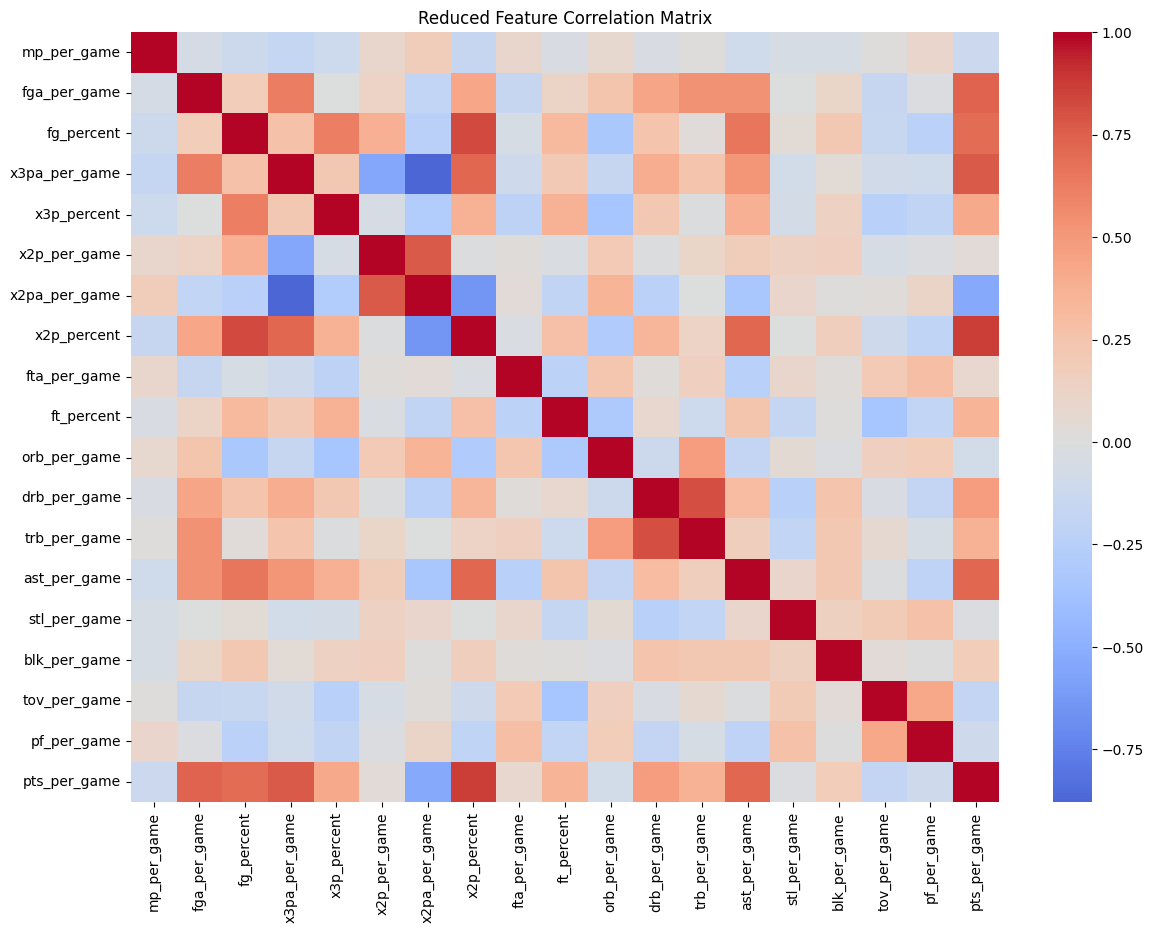

In [17]:
plt.figure(figsize=(14, 10))
sns.heatmap(features_reduced.corr(), annot=False, cmap='coolwarm', center=0)
plt.title("Reduced Feature Correlation Matrix")
plt.show()


## PCA for Visualization (2D) - for visualizing clusters

To gain a visual understanding of the structure of the dataset, Principal Component Analysis (PCA) was applied to reduce the high-dimensional standardized feature set down to just two components (PC1 and PC2). PCA transforms the original features into new axes that capture the maximum variance in the data while preserving the most important patterns.

In [18]:
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_df_reduced)

# Create DataFrame with PCA components
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['playoffs'] = team_labels['playoffs'].values


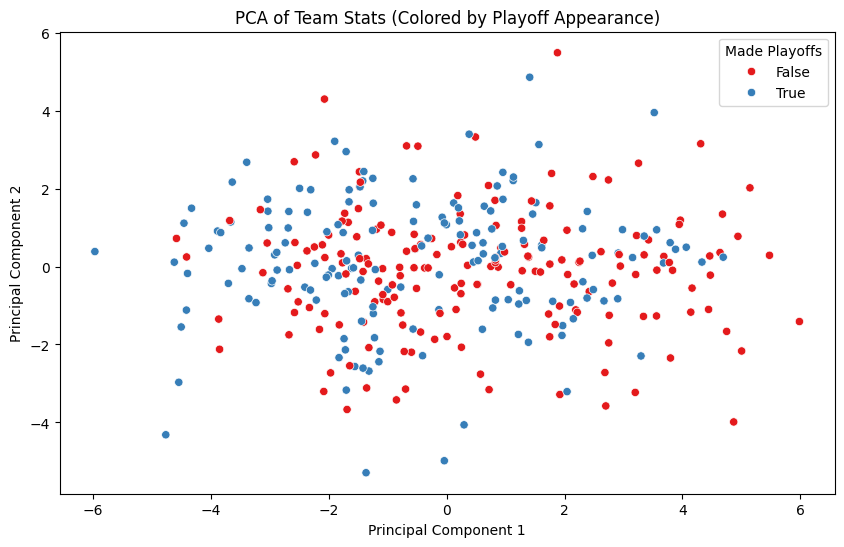

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='playoffs', palette='Set1')
plt.title('PCA of Team Stats (Colored by Playoff Appearance)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Made Playoffs')
plt.show()


### PCA Visualization Result: No Clear Separation by Playoff Status

The 2D PCA scatterplot shows the projection of all teams onto the first two principal components, with points colored by playoff status. Visually, there is no distinct separation between playoff and non-playoff teams in this reduced space.

This result suggests:

- Team performance characteristics do not linearly separate playoff teams from non-playoff teams in the first two principal components.

- The variance captured by PC1 and PC2, while useful for dimensionality reduction, does not align strongly with playoff outcomes.

- Playoff status likely depends on a complex combination of features that may not be well represented in just two linear dimensions.

- It also reinforces the idea that while unsupervised models can find structure, success (like making the playoffs) may not emerge as a simple or visually obvious cluster.

📌 In other words: team performance profiles vary along continuous gradients, and playoff status appears to exist across that spectrum rather than forming clear-cut clusters.

### 🔁 What’s Next?
This outcome doesn't mean clustering is useless — it just means:

- We shouldn’t expect perfect separation between playoff groups

- Clustering may still reveal team archetypes (e.g., high-rebound/low-turnover teams) that are more or less associated with success

- We will explore clustering as a tool to characterize styles, not necessarily predict outcomes directly

## 🎯 K-Means Clustering to Discover Team Archetypes
Following the PCA visualization — which showed no clear linear separation between playoff and non-playoff teams — we proceed to apply K-Means clustering to explore whether meaningful groupings of team performance profiles emerge in an unsupervised way.

### Determine the Optimal Number of Clusters using Elbow Method

-  This involves plotting the inertia (sum of squared distances from each point to its assigned cluster center) across a range of k values.

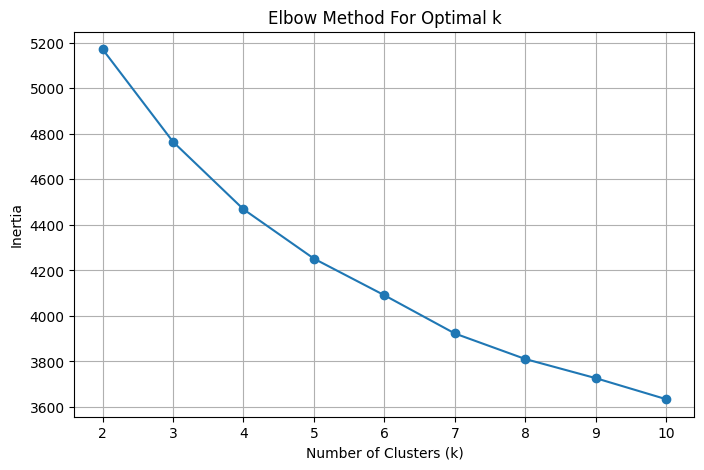

In [20]:
from sklearn.cluster import KMeans

# Try cluster sizes 2–10
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    kmeans.fit(scaled_df_reduced)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()


### In this case, an elbow appears around k = 5, which is chosen for the final model.

## Testing Silhouette Scores

In [37]:

from sklearn.metrics import silhouette_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = kmeans.fit_predict(scaled_df_reduced)
    score = silhouette_score(scaled_df_reduced, labels)
    print(f"k = {k}, Silhouette Score = {score:.4f}")


k = 2, Silhouette Score = 0.1773
k = 3, Silhouette Score = 0.1225
k = 4, Silhouette Score = 0.1192
k = 5, Silhouette Score = 0.0965
k = 6, Silhouette Score = 0.0951
k = 7, Silhouette Score = 0.0954
k = 8, Silhouette Score = 0.0955
k = 9, Silhouette Score = 0.0926
k = 10, Silhouette Score = 0.0852


### Based on the silhouette scores, the strongest natural separation in the data occurs at k = 2 (score = 0.177). However, for the purpose of discovering distinct team archetypes and generating richer insights, we selected k = 5 despite a lower silhouette score (0.096). This reflects a trade-off between mathematical separation and practical interpretability.


## Apply K-Means Clustering to the Standardized and Reduced dimensions dataset

In [38]:
# Fit KMeans
k = 5

kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
clusters = kmeans.fit_predict(scaled_df_reduced)

# Add cluster labels to PCA DataFrame
pca_df['cluster'] = clusters


### Visualize the clusters

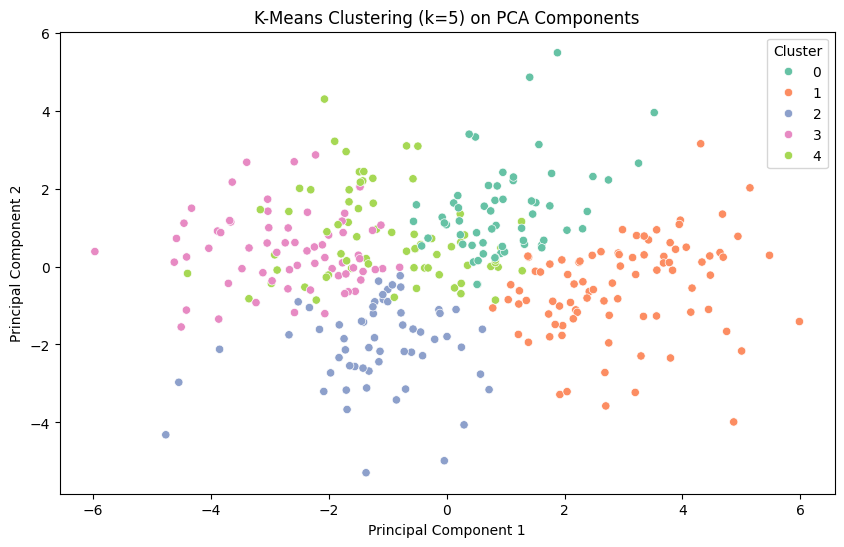

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='Set2')
plt.title(f'K-Means Clustering (k={k}) on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


# Analyzing Clusters

#### Create custom color pallete

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Define a consistent palette for clusters
cluster_palette = sns.color_palette('Set2', k)  # same as in PCA plot
cluster_color_dict = {i: cluster_palette[i] for i in range(k)}  # cluster id to color

#### Bar Chart of Each Cluster's playoff Percentage

C:\Users\u389375\AppData\Local\Temp\ipykernel_27612\1058372689.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


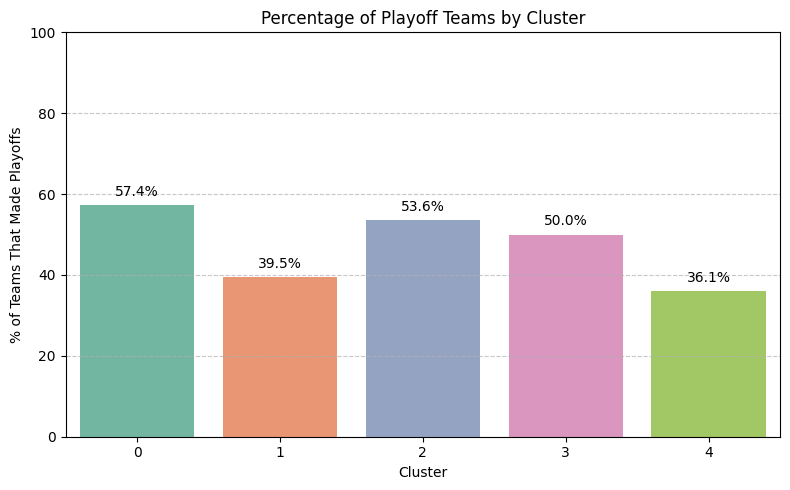

In [41]:
# Merge cluster labels with team info
cluster_eval = pca_df.copy()
cluster_eval['team'] = team_labels['team']
cluster_eval['season'] = team_labels['season']
cluster_eval['playoffs'] = team_labels['playoffs']

# Compute playoff % per cluster
cluster_summary = cluster_eval.groupby('cluster')['playoffs'].value_counts().unstack().fillna(0)
cluster_summary.columns = ['Non-Playoff', 'Playoff']
cluster_summary['Total'] = cluster_summary.sum(axis=1)
cluster_summary['% Playoff Teams'] = 100 * cluster_summary['Playoff'] / cluster_summary['Total']

# Plot bar chart with labels
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=cluster_summary.index,
    y=cluster_summary['% Playoff Teams'],
    palette=[cluster_color_dict[i] for i in cluster_summary.index]
)

# Add value labels on top of bars
for i, value in enumerate(cluster_summary['% Playoff Teams']):
    ax.text(i, value + 1.5, f"{value:.1f}%", ha='center', va='bottom', fontsize=10)

plt.title("Percentage of Playoff Teams by Cluster")
plt.xlabel("Cluster")
plt.ylabel("% of Teams That Made Playoffs")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Bar Chart comparing the normalized mean values for key features across clusters

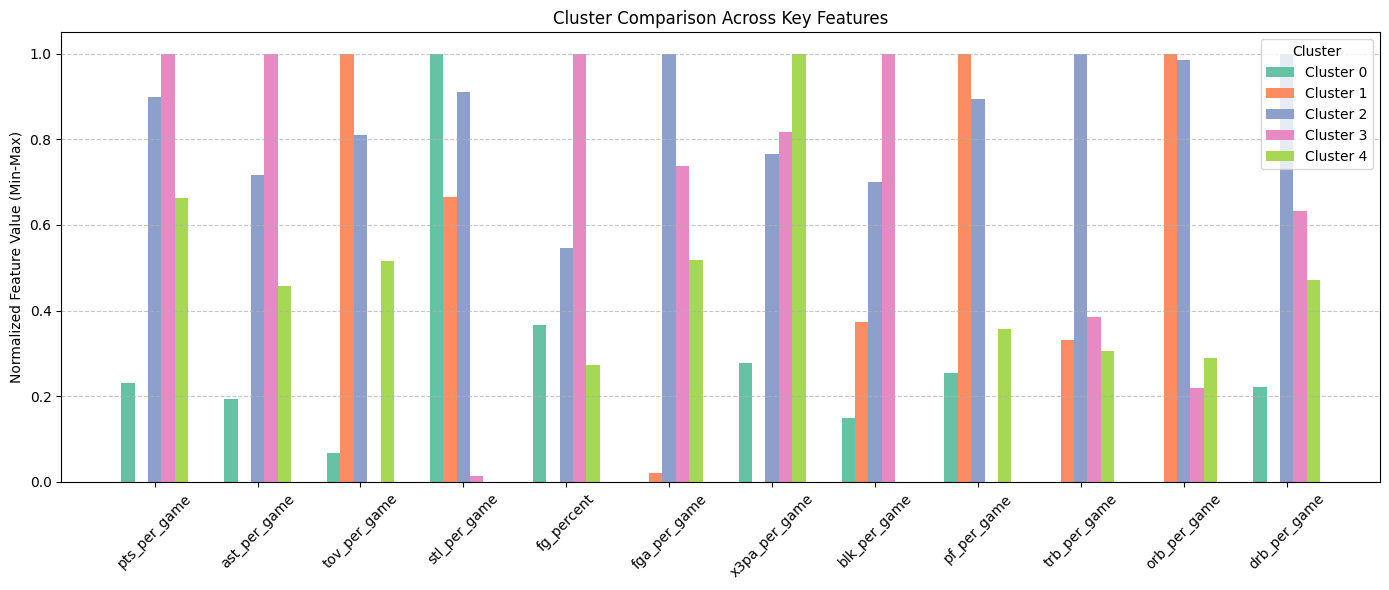

In [42]:
# Merge cluster labels with unscaled features
features_with_clusters = features_reduced.copy()
features_with_clusters['cluster'] = clusters
features_with_clusters['playoffs'] = team_labels['playoffs'].values

# Compute mean values per cluster (raw values)
cluster_profiles = features_with_clusters.groupby('cluster').mean().drop(columns='playoffs')

# Select key features to plot
features_to_plot = ['pts_per_game', 'ast_per_game', 'tov_per_game', 'stl_per_game', 'fg_percent', 'fga_per_game', 'x3pa_per_game','blk_per_game',
                   'pf_per_game','trb_per_game', 'orb_per_game', 'drb_per_game']

# Normalize selected features for comparison across clusters
scaler = MinMaxScaler()
normalized_cluster_profiles = pd.DataFrame(
    scaler.fit_transform(cluster_profiles[features_to_plot]),
    columns=features_to_plot,
    index=cluster_profiles.index
)

# Grouped bar chart
n_features = len(features_to_plot)
n_clusters = len(normalized_cluster_profiles)
bar_width = 0.13
index = np.arange(n_features)

plt.figure(figsize=(14, 6))

for i, cluster_id in enumerate(normalized_cluster_profiles.index):
    plt.bar(index + i * bar_width,
            normalized_cluster_profiles.loc[cluster_id],
            bar_width,
            label=f'Cluster {cluster_id}',
            color=cluster_color_dict[cluster_id])

plt.xticks(index + bar_width * (n_clusters / 2 - 0.5), features_to_plot, rotation=45)
plt.ylabel('Normalized Feature Value (Min-Max)')
plt.title('Cluster Comparison Across Key Features')
plt.legend(title='Cluster')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [43]:
# Display raw (non-normalized) feature means per cluster
pd.set_option('display.float_format', '{:.2f}'.format)  # prettier formatting
display(cluster_profiles.T)  # Transposed for easier reading

cluster,0,1,2,3,4
mp_per_game,241.57,241.89,241.84,241.52,241.28
fga_per_game,84.42,84.54,89.94,88.50,87.28
fg_percent,0.46,0.45,0.47,0.48,0.46
x3pa_per_game,26.44,22.76,32.93,33.63,36.05
x3p_percent,0.37,0.35,0.35,0.37,0.36
x2p_per_game,29.15,29.96,30.22,30.01,26.93
x2pa_per_game,57.99,61.78,57.01,54.87,51.23
x2p_percent,0.50,0.49,0.53,0.55,0.53
fta_per_game,22.08,23.38,23.66,21.64,22.59
ft_percent,0.77,0.75,0.76,0.79,0.78


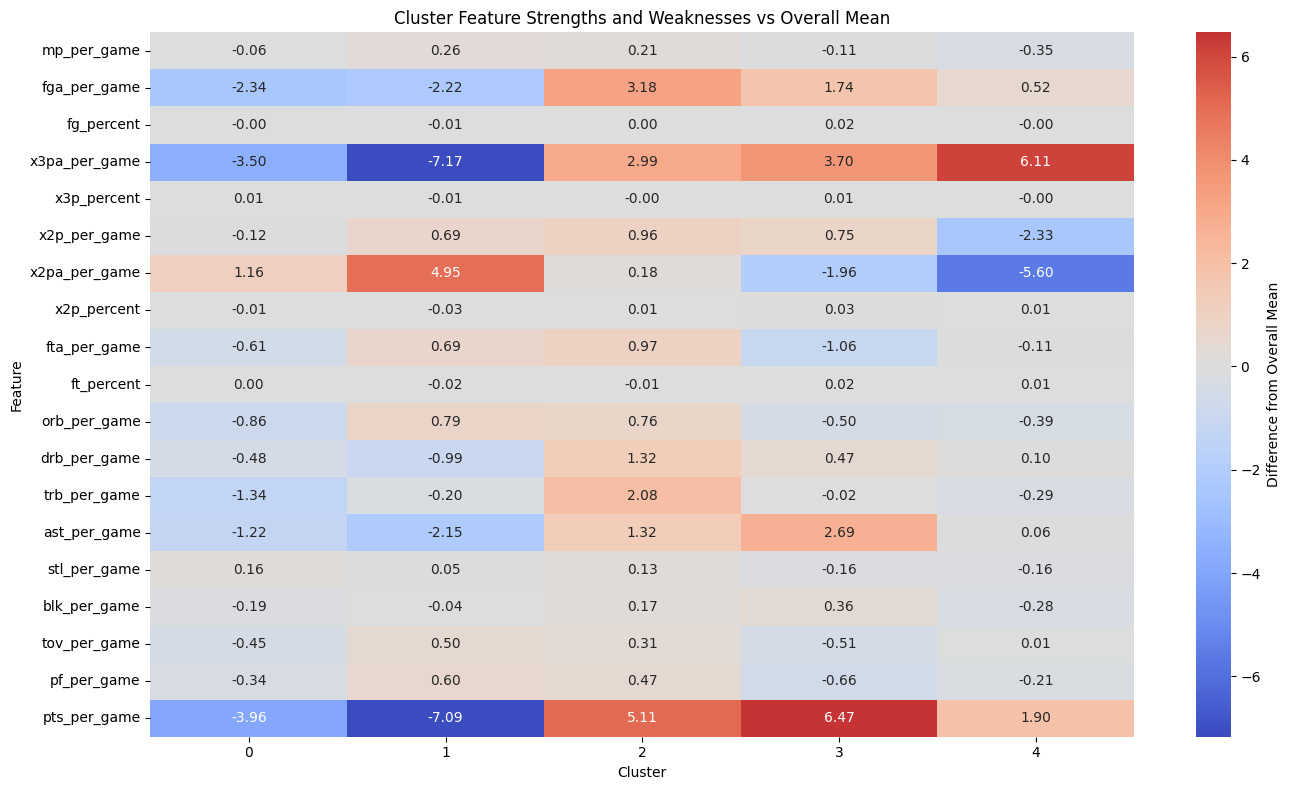

In [44]:
# Step 1: Get overall average per feature
overall_means = features_reduced.mean()

# Step 2: Calculate difference of each cluster’s mean from overall average
cluster_deviation = cluster_profiles - overall_means

# Optional: Round for readability
cluster_deviation = cluster_deviation.round(2)

plt.figure(figsize=(14, 8))
sns.heatmap(cluster_deviation.T, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            cbar_kws={'label': 'Difference from Overall Mean'})
plt.title("Cluster Feature Strengths and Weaknesses vs Overall Mean")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Cluster Distribution over time

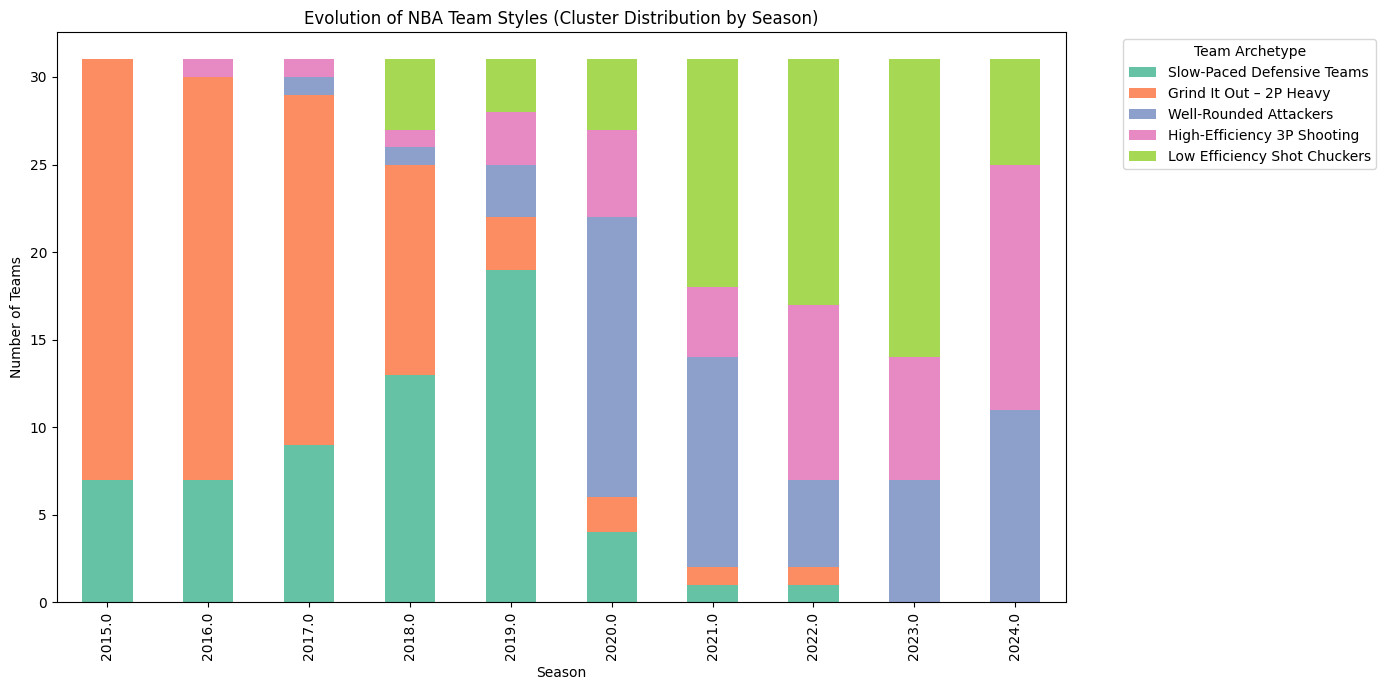

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Mapping from cluster ID to descriptive label
cluster_label_map = {
    0: "Slow-Paced Defensive Teams",
    1: "Grind It Out – 2P Heavy",
    2: "Well-Rounded Attackers",
    3: "High-Efficiency 3P Shooting",
    4: "Low Efficiency Shot Chuckers"
}

# Create label and palette mappings
cluster_eval_labeled = cluster_eval.copy()
cluster_eval_labeled['cluster_label'] = cluster_eval_labeled['cluster'].map(cluster_label_map)

# Crosstab for cluster distribution by season
pivot = pd.crosstab(cluster_eval_labeled['season'], cluster_eval_labeled['cluster_label'])

# Ensure label order matches cluster IDs
ordered_labels = [cluster_label_map[i] for i in range(len(cluster_label_map))]
pivot = pivot[ordered_labels]

# Apply the original color palette using the cluster_color_dict
label_color_map = {cluster_label_map[i]: cluster_color_dict[i] for i in cluster_label_map}
colors = [label_color_map[label] for label in ordered_labels]

# Plot the stacked bar chart with consistent colors
pivot.plot(kind='bar', stacked=True, figsize=(14, 7), color=colors)

plt.title("Evolution of NBA Team Styles (Cluster Distribution by Season)")
plt.xlabel("Season")
plt.ylabel("Number of Teams")
plt.legend(title="Team Archetype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



# Results/Conclusion

This project applied unsupervised learning — specifically the K-Means clustering algorithm — to analyze and uncover patterns in NBA team performance data from the 2014 to 2024 seasons. After extensive data exploration and preprocessing, including feature normalization and multicollinearity reduction, the dataset was reduced to a refined set of statistical features representing each team's playing style.

Although Principal Component Analysis (PCA) showed no clear separation between playoff and non-playoff teams in lower dimensions, the underlying hypothesis shifted toward discovering natural team archetypes using clustering. K-Means was selected for its interpretability and stability, with the optimal number of clusters (k=5) determined via the elbow method and supported by silhouette score analysis.

The clustering process revealed five distinct team archetypes, which were given descriptive labels based on their average feature profiles — such as "Grind-It-Out 2P Heavy" or "High-Efficiency 3P Shooting". These clusters were evaluated against playoff success, and a visualization of their distribution over time illustrated a clear strategic evolution across the league. Earlier seasons were dominated by slower-paced, 2-point heavy teams, while recent seasons reflected a shift toward higher scoring, faster-paced offenses with greater emphasis on three-point shooting — aligning with well-known league-wide trends.

The final outputs included:

- A bar chart showing playoff success rates for each cluster

- Grouped feature comparisons to highlight statistical differences between clusters

- A season-by-season timeline illustrating how team styles have shifted over the past decade

- A decision tree model to interpret which features were most influential in defining clusters

Overall, this project demonstrates how unsupervised learning can uncover latent structure in sports data, offering both interpretable team segmentation and a compelling lens into the tactical evolution of modern NBA basketball.